In [2]:
import pandas as pd
import numpy as np
import glob

from skbio import OrdinationResults
from scipy.stats import wilcoxon, kruskal, mannwhitneyu
from gemelli.rpca import joint_rpca
from biom import load_table

#plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm # for a scatter plot

%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import 
metadata = pd.read_csv('../network/split-matched-data/metadata.tsv', index_col=0, sep='\t')
tables = {i.split('/')[-1].split('.')[0]:load_table(i) for i in glob.glob('../network/split-matched-data/*') if 'metadata' not in i}

In [42]:
#remove the metabolomics table for reproducibility
#del tables['metabolomics']

In [4]:
print(metadata.shape)
display(metadata.head())

(374, 16)


season subjects  add_0c add_0c_group  \
sample_name                                                                 
soil.hip.CMU.17.10.2017.08.11.day3   summer    17-10   49.75        early   
soil.hip.CMU.17.10.2017.08.22.day14  summer    17-10  322.80     advanced   
soil.hip.CMU.17.10.2017.08.28.day20  summer    17-10  477.80     advanced   
soil.hip.CMU.17.10.2017.08.09.day1   summer    17-10    0.00      initial   
soil.hip.CMU.17.10.2017.08.23.day15  summer    17-10  348.05     advanced   

                                    facility  timepoint traintest_0  \
sample_name                                                           
soil.hip.CMU.17.10.2017.08.11.day3      FIRS          3       train   
soil.hip.CMU.17.10.2017.08.22.day14     FIRS         14        test   
soil.hip.CMU.17.10.2017.08.28.day20     FIRS         20        test   
soil.hip.CMU.17.10.2017.08.09.day1      FIRS          1       train   
soil.hip.CMU.17.10.2017.08.23.day15     FIRS         15       train   

                                    traintest_1 traintest_2 traintest_3  \
sample_name                                                               
soil.hip.CMU.17.10.2017.08.11.day3        train       train       train   
soil.hip.CMU.17.10.2017.08.22.day14        test        test        test   
soil.hip.CMU.17.10.2017.08.28.day20        test        test        test   
soil.hip.CMU.17.10.2017.08.09.day1        train       train       train   
soil.hip.CMU.17.10.2017.08.23.day15       train       train       train   

                                    traintest_4 traintest_5 traintest_6  \
sample_name                                                               
soil.hip.CMU.17.10.2017.08.11.day3        train       train       train   
soil.hip.CMU.17.10.2017.08.22.day14        test        test        test   
soil.hip.CMU.17.10.2017.08.28.day20        test        test        test   
soil.hip.CMU.17.10.2017.08.09.day1        train       train       train   
soil.hip.CMU.17.10.2017.08.23.day15       train       train       train   

                                    traintest_7 traintest_8 traintest_9  
sample_name                                                              
soil.hip.CMU.17.10.2017.08.11.day3        train       train       train  
soil.hip.CMU.17.10.2017.08.22.day14        test        test        test  
soil.hip.CMU.17.10.2017.08.28.day20        test        test        test  
soil.hip.CMU.17.10.2017.08.09.day1        train       train       train  
soil.hip.CMU.17.10.2017.08.23.day15       train       train       train

In [5]:
id_split_lst = []
for id in metadata.index:
    id_split = ('.').join(id.split('.')[0:3])
    id_split_lst.append(id_split)
    
metadata['id_site'] = id_split_lst

In [6]:
print(metadata.facility.value_counts())
print(metadata.id_site.value_counts())

facility
ARF      191
STAFS    125
FIRS      58
Name: count, dtype: int64
id_site
soil.hip.UTK         191
soil.hip.SHSU        124
soil.hip.CMU          58
soil.hip.SHSU2016      1
Name: count, dtype: int64


In [11]:
def ordination_scatterplots(rpca_results, metadata, x="PC1", y="PC2",
                            hue=None, hue_order=None, palette="tab10", 
                            markers=None, style=None, style_order=None, 
                            point_size=100, subplots=(2,3), figsize=(25, 10)):

    if subplots is not None:
        fig, axn = plt.subplots(subplots[0], subplots[1], figsize=figsize)
        axn = axn.flatten()
    else:
        fig = plt.figure(figsize=figsize)
        axn = [plt.gca()]

    for ax, (tblid, (ord_, _, _)) in zip(axn, rpca_results.items()):
        #prepare dataframe
        ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                                   2:'PC3', 3:'PC4'})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)
        
        #plotting
        sns.scatterplot(x=x, y=y, hue=hue, hue_order=hue_order, 
                        palette=palette, style=style, 
                        style_order=style_order, markers=markers, 
                        data=ord_plt, s=point_size, ax=ax)
        ax.set_xlabel(x, color='black', weight='bold', fontsize=22)
        ax.set_ylabel(y, color='black', weight='bold', fontsize=22)
        ax.set_title(tblid, color='black', weight='bold', fontsize=22)
        # fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(14)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(14)
        ax.legend_.remove()
        
    plt.tight_layout()

    if subplots is not None:
        legend = ax.legend(loc=2, bbox_to_anchor=(-1.1, 2.6),
                           prop={'size':22}, title="",
                           fancybox=True, framealpha=.0,
                           ncol=len(hue_order), markerscale=3.5)
        legend.get_title().set_fontsize('16')
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
    else:
        legend = ax.legend(loc=2, bbox_to_anchor=(1, 1),
                           prop={'size':18}, title="",
                           fancybox=True, framealpha=.0,
                           ncol=1, markerscale=3.5)
        legend.get_title().set_fontsize('16')
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        
    plt.show()

In [7]:
def ord_scatter_3D(rpca_results, metadata, 
                   hue, hue_order, 
                   pcs=["PC1","PC2","PC3"], palette="tab10", 
                   subplots=(2,3), figsize=(25, 10)):

    if subplots is not None:
        fig, axn = plt.subplots(subplots[0], subplots[1], figsize=figsize,
                                subplot_kw=dict(projection='3d'))
        axn = axn.flatten()
    else:
        ax = plt.figure(figsize=figsize).add_subplot(projection='3d')
        axn = [ax]

    for ax, (tblid, (ord_, _, _)) in zip(axn, rpca_results.items()):
        #prepare dataframe
        ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                                   2:'PC3', 3:'PC4'})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)
        #assign colors
        color_dict = dict(zip(hue_order, palette))
        ord_plt['Color'] = ord_plt[hue].map(color_dict)

        ax.scatter(xs=ord_plt[pcs[0]], ys=ord_plt[pcs[1]], zs=ord_plt[pcs[2]], 
                   c=ord_plt['Color'], marker='o')

        ax.set_xlabel(pcs[0], color='black', weight='bold', fontsize=15)
        ax.set_ylabel(pcs[1], color='black', weight='bold', fontsize=15)
        ax.set_zlabel(pcs[2], color='black', weight='bold', fontsize=15)
        ax.set_title(tblid, color='black', weight='bold', fontsize=15)

        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 15
        ax.zaxis.labelpad = 15
        
        # fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

    patches = [mpatches.Patch(color=value, label=key) for key, value in color_dict.items()]
    if subplots is not None:
        legend = ax.legend(handles=patches, loc=9, title='', prop={'size':18},
                           bbox_to_anchor=(-0.9, 2.5), fancybox=True, framealpha=.0,
                           ncol=len(hue_order), markerscale=3.5)
        legend.get_title().set_fontsize('16')
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        fig.subplots_adjust(wspace=-0.5, hspace=0.2)
    
    else:
        legend = ax.legend(handles=patches, loc=2, bbox_to_anchor=(1.05, 1.1),
                           title='', prop={'size':18}, fancybox=True, framealpha=.0,
                           ncol=1, markerscale=3.5)
        legend.get_title().set_fontsize('16')

        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
    
    #plt.tight_layout()
    plt.show()

## independent RPCA

In [16]:
n_PCS = 4

In [21]:
# # ONLY RUN ON FIRST ITERATION
# # check indpendent analysis
# fold = 0
# rpca_independent = {tblid:joint_rpca([tbl], n_components=n_PCS, max_iterations=15,
#                                      min_feature_count=10, sample_metadata=metadata,
#                                      train_test_column='traintest_%i' % fold)
#                     for tblid, tbl in tables.items()}

# cvs_ind = {(fold, datatype_):cv_tmp_dt for datatype_, (_, _, cv_tmp_dt) in rpca_independent.items()}
# cvs_ind_all = pd.concat(cvs_ind).reset_index().rename({'level_0':'fold', 'level_1':'modality'}, axis=1)
# sns.pointplot(x='iteration', y='mean_CV', hue='modality', data=cvs_ind_all)
# plt.show()

In [47]:
# save results
#for tblid, (ord_, dist_, _) in rpca_independent.items():    
#    ord_.write('../results/joint-rpca/%s_ord_4PCs.txt' % tblid)
#    dist_.write('../results/joint-rpca/%s_dist_4PCs.txt' % tblid)

In [8]:
# load results form prior run
omic_ids = ['metabolite', '16S', 'mag', '18S', 'gene_module', 'gene', 'metabolomics']

rpca_independent = {omic: (OrdinationResults.read('../results/joint-rpca/{}_ord_4PCs.txt'.format(omic)),
                           None, ##we don't really need the distance matrix for the analysis here! 
                           None) for omic in omic_ids}

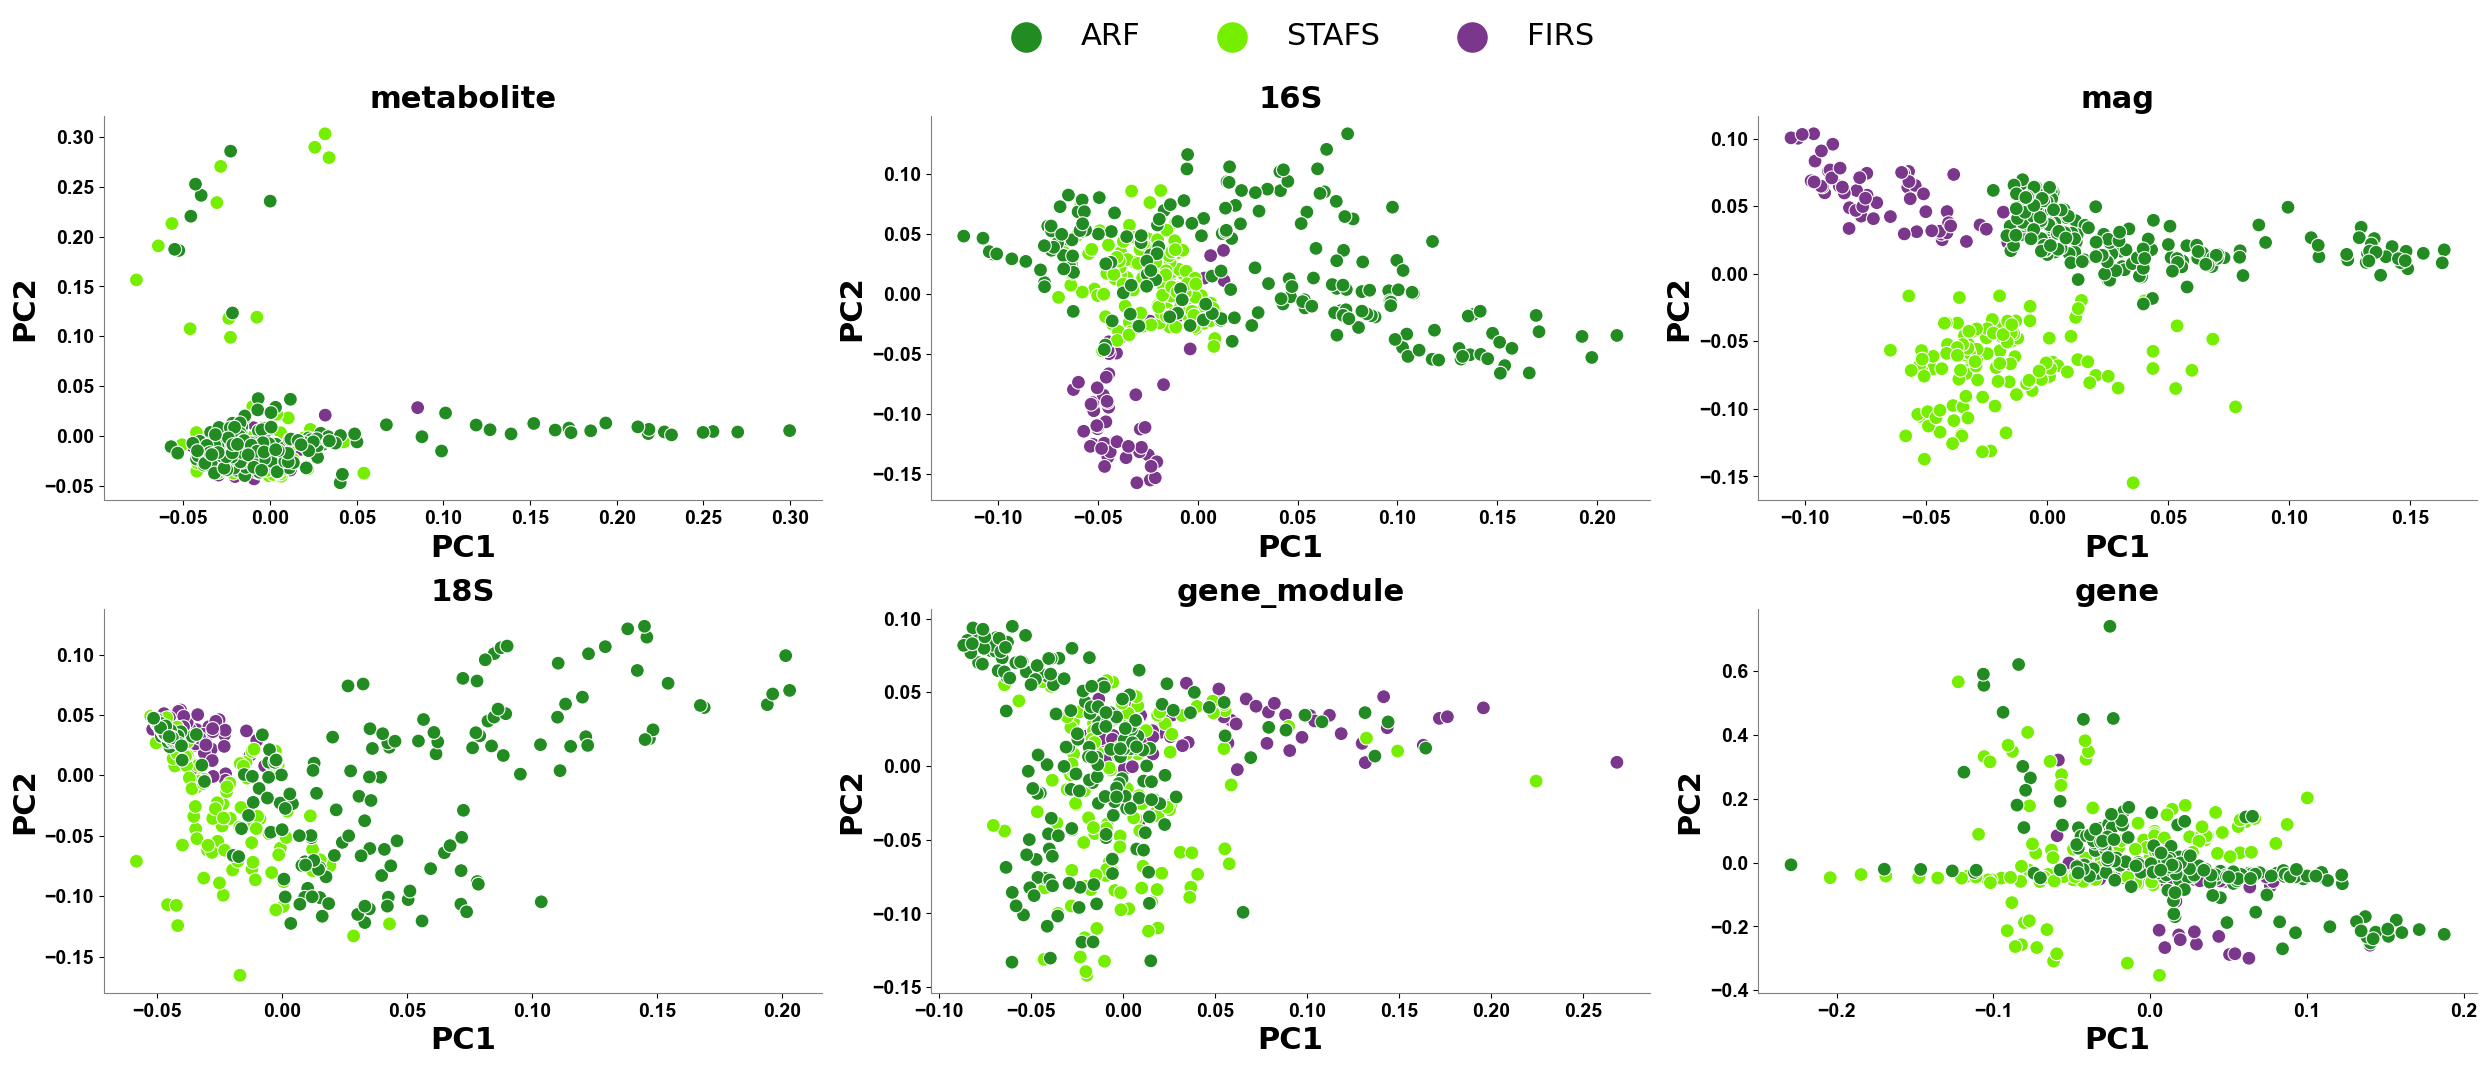

In [9]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
                        x="PC1", y="PC2", palette=["#228b22","#76ee00","#7a378b"], 
                        subplots=(2,3), figsize=(25, 10))

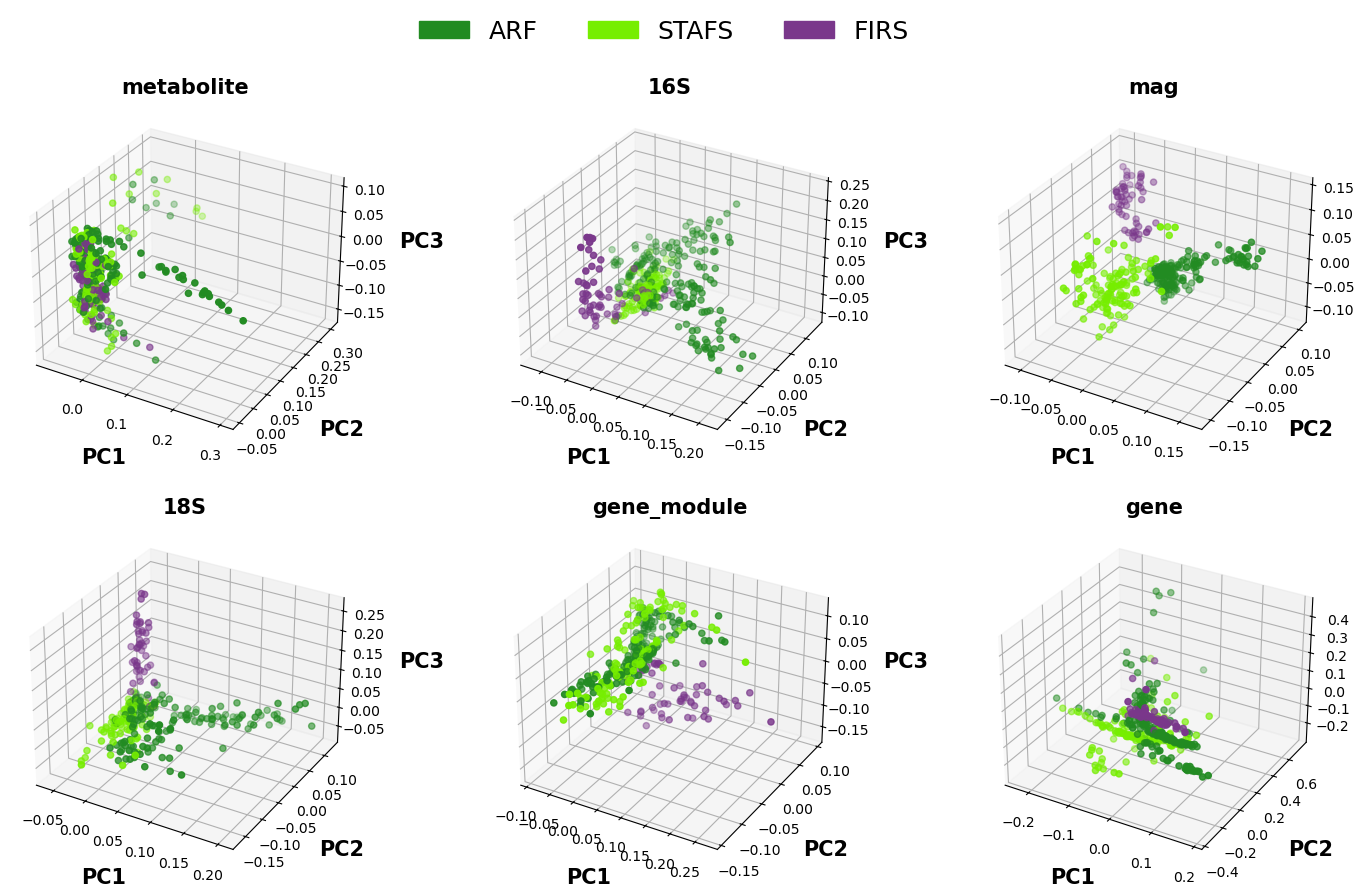

In [10]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
               pcs=["PC1","PC2","PC3"], palette=["#228b22","#76ee00","#7a378b"], 
               subplots=(2,3), figsize=(25, 10))

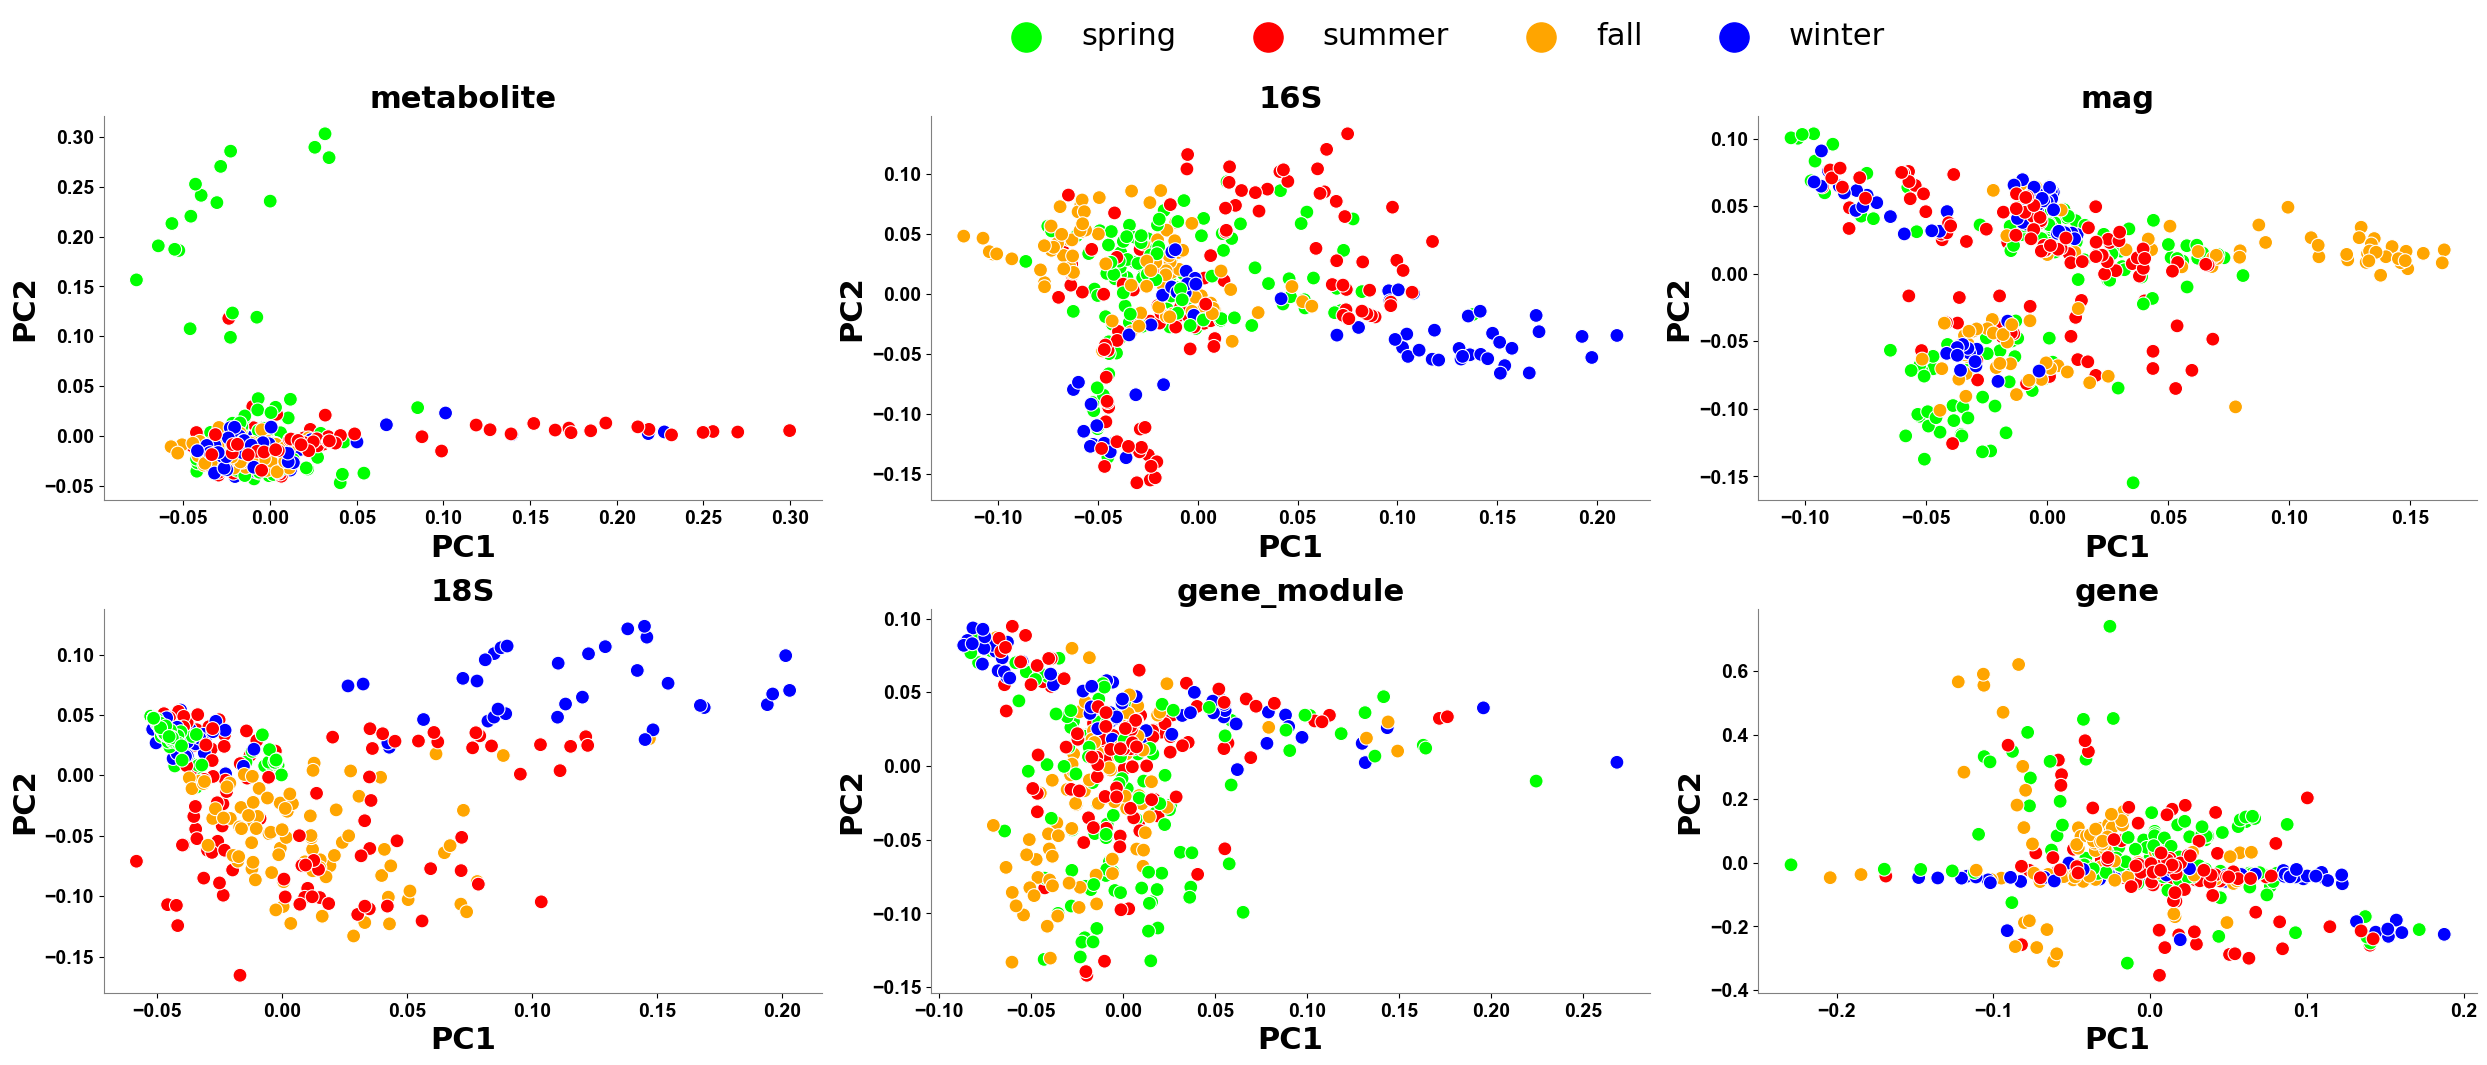

In [11]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="season", hue_order=['spring', 'summer', 'fall','winter'], 
                        x="PC1", y="PC2", palette=["#00FF00","#FF0000","#FFA500", "#0000FF"], 
                        subplots=(2,3), figsize=(25, 10))

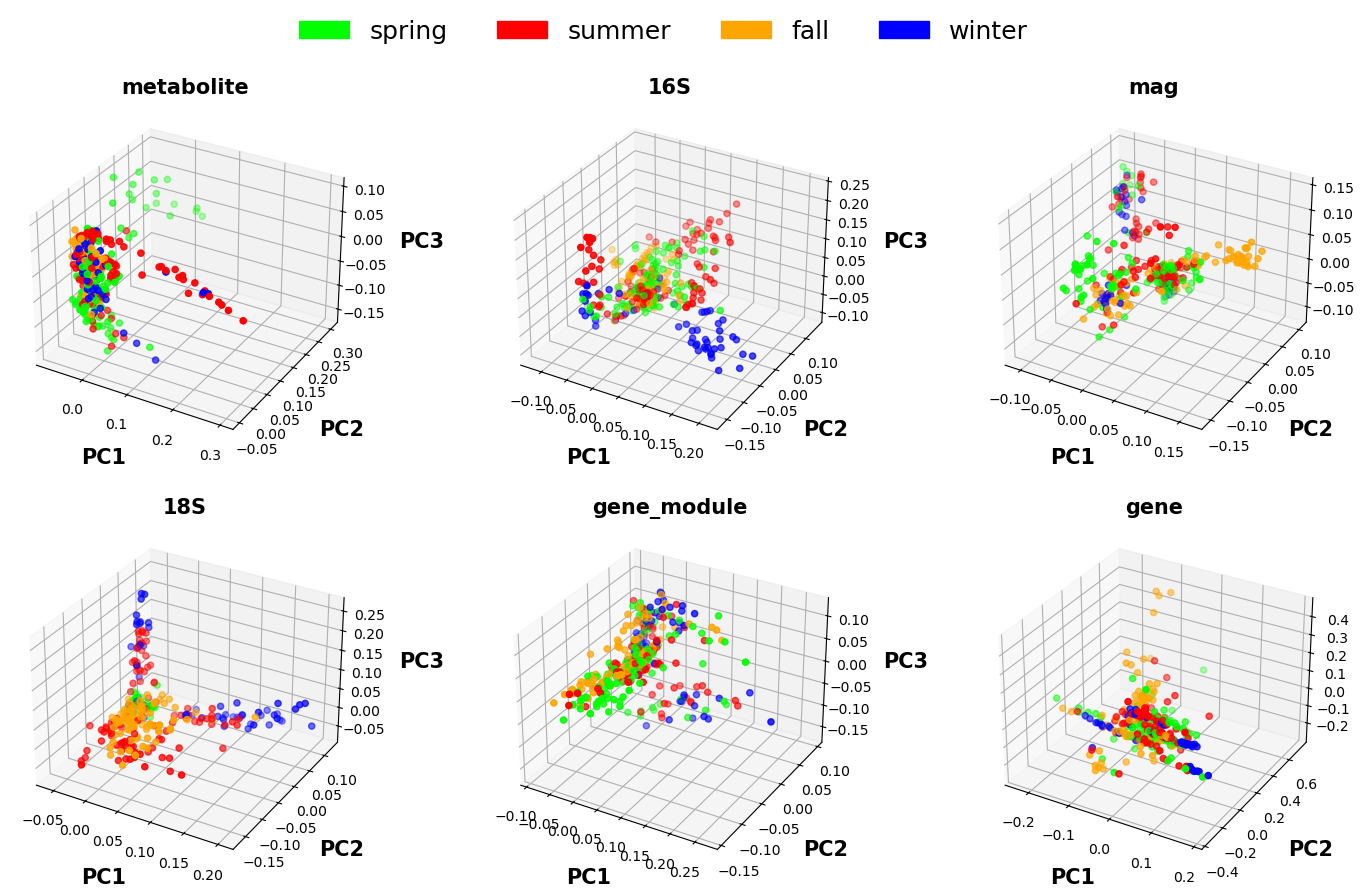

In [12]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="season", hue_order=['spring', 'summer', 'fall','winter'], 
               pcs=["PC1","PC2","PC3"], palette=["#00FF00","#FF0000","#FFA500", "#0000FF"], 
               subplots=(2,3), figsize=(25, 10))

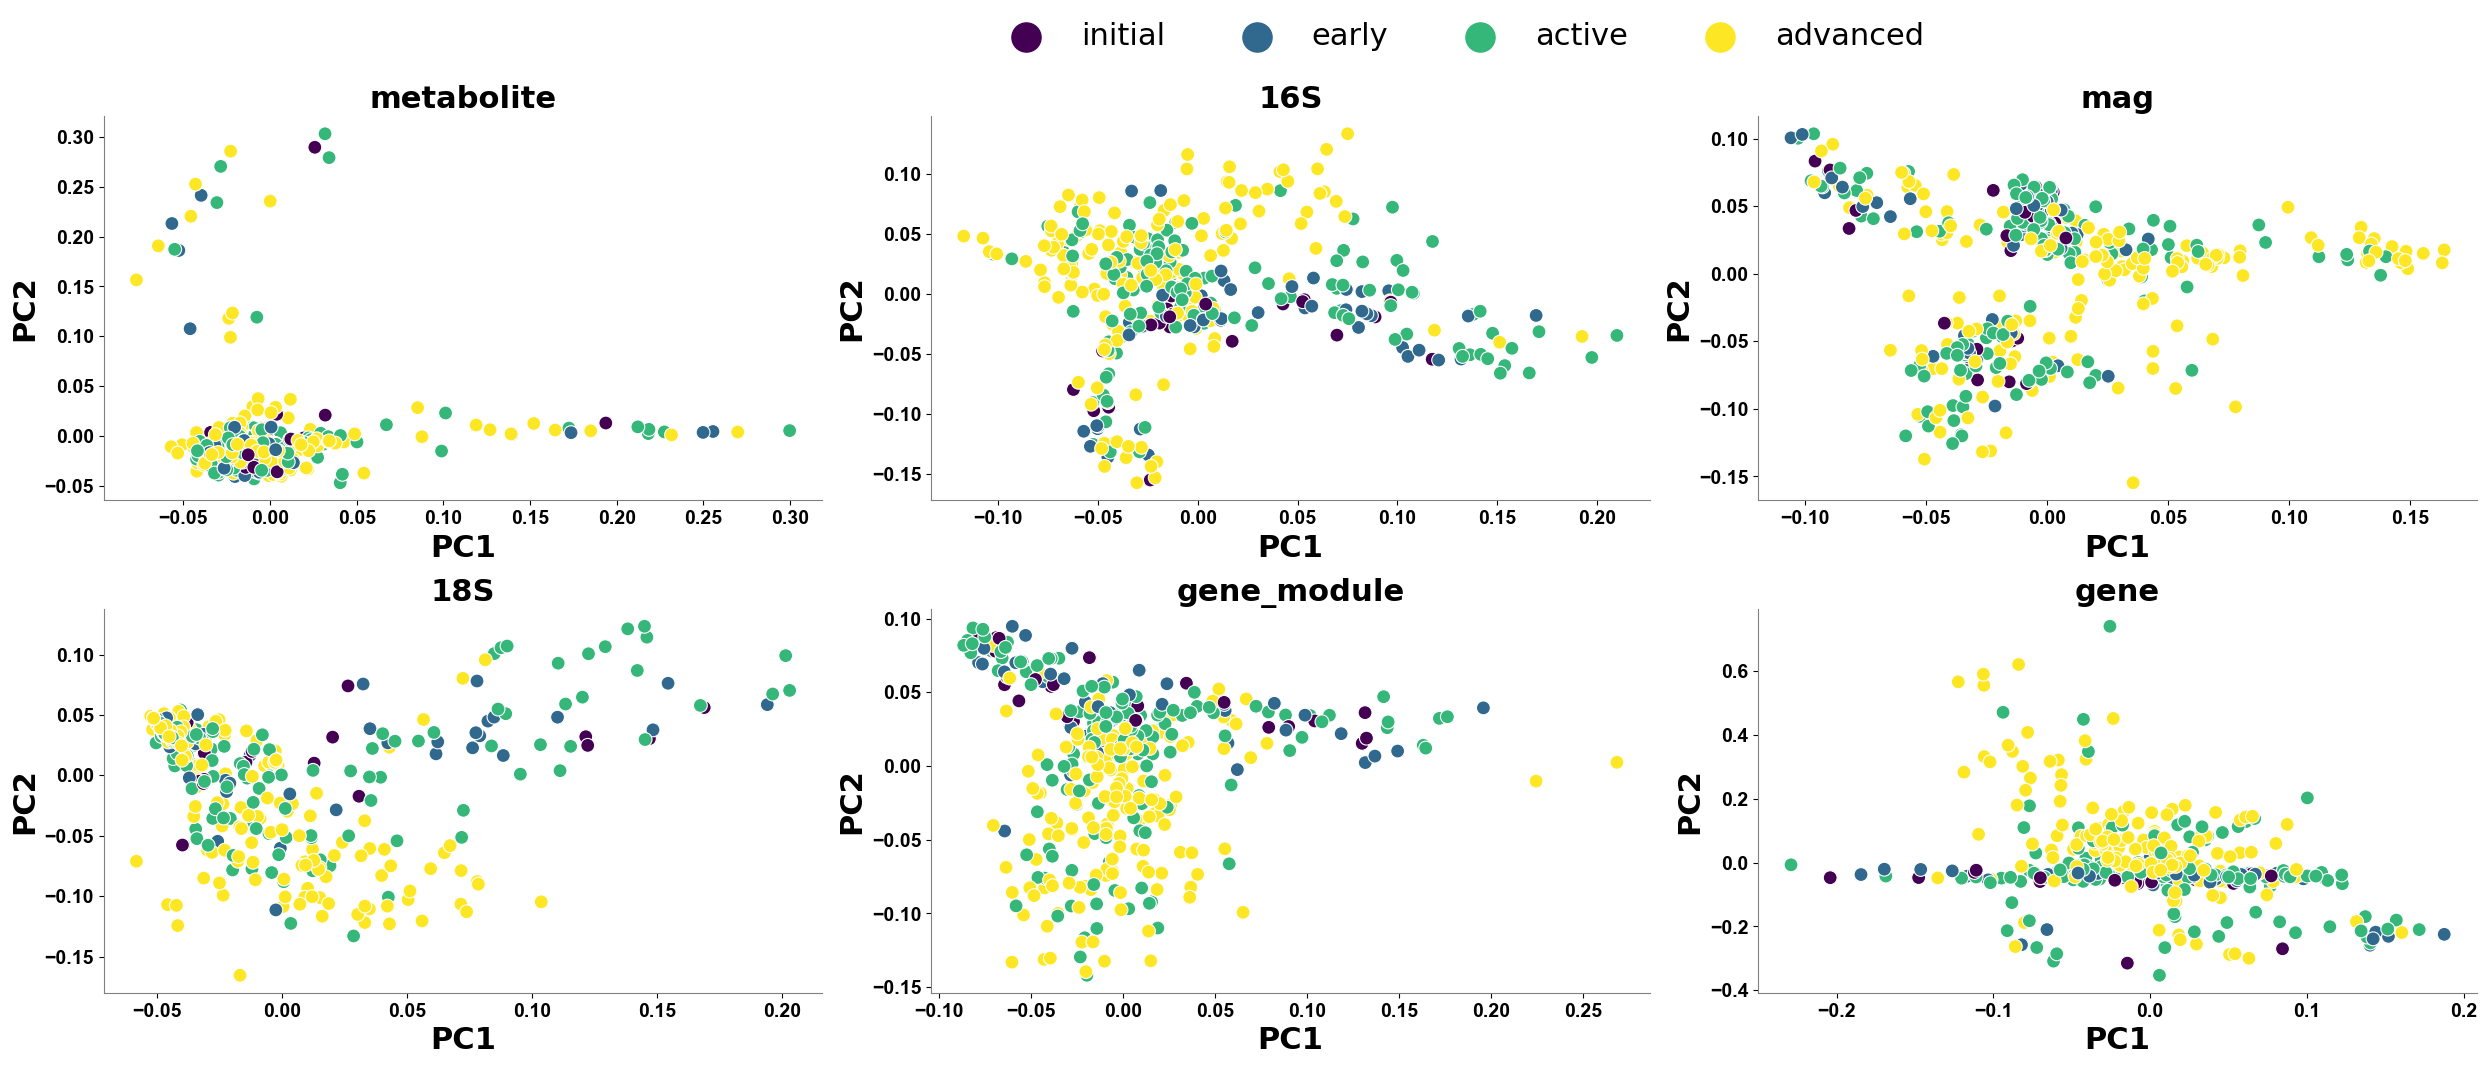

In [13]:
ordination_scatterplots(rpca_independent, metadata, 
                        hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
                        x="PC1", y="PC2", palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"], 
                        subplots=(2,3), figsize=(25, 10))

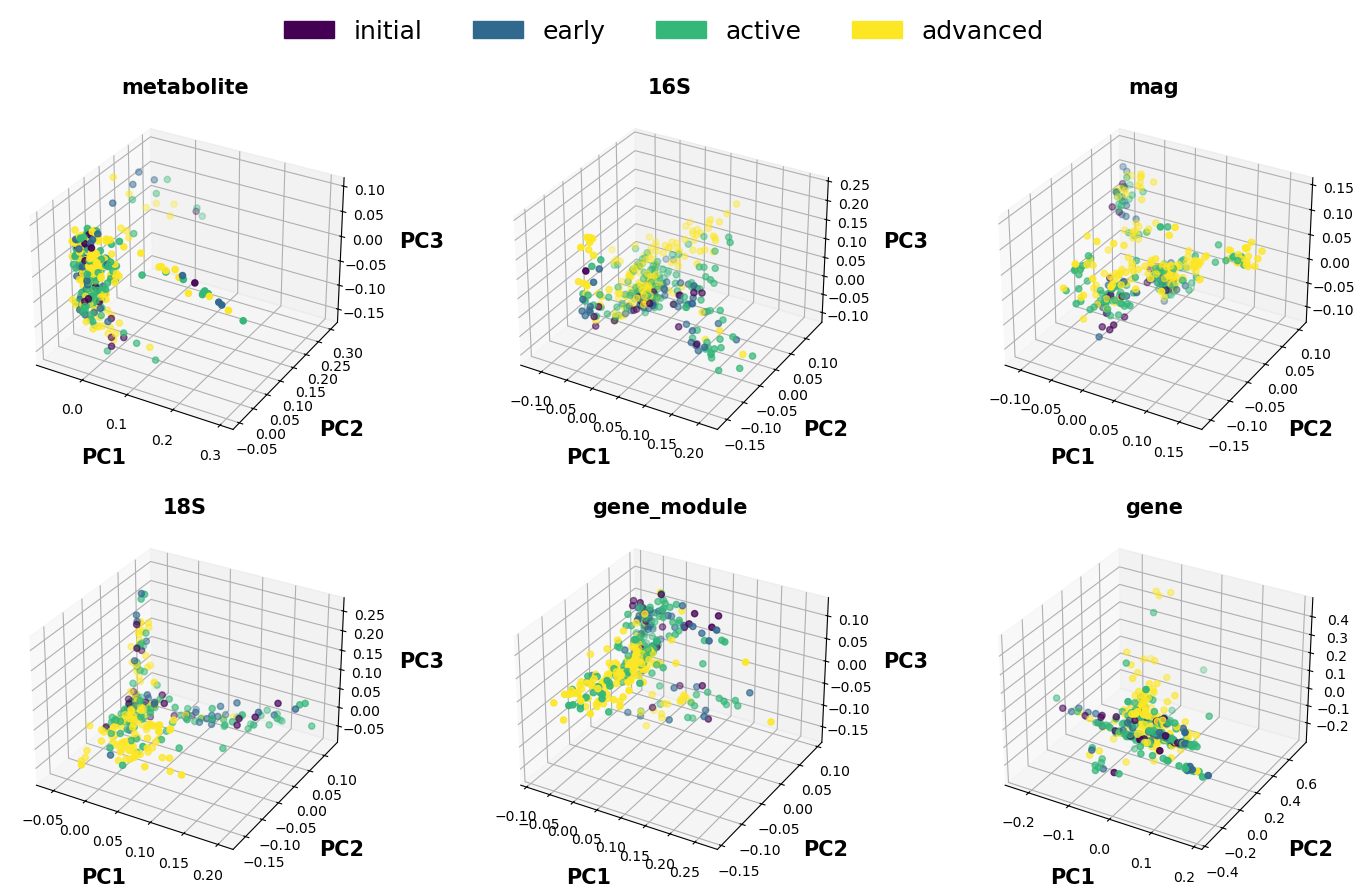

In [14]:
ord_scatter_3D(rpca_independent, metadata, 
               hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
               pcs=["PC1","PC2","PC3"], palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"], 
               subplots=(2,3), figsize=(25, 10))

In [17]:
cats_of_interest = ['facility', 'season', 'add_0c_group']
kw_df_all = []

for cat_of_interest in cats_of_interest:
    kw_df_cat = pd.DataFrame()

    for tblid, (ord_, _, _) in rpca_independent.items():    
        ord_samples = ord_.samples.rename(columns={0:"PC1", 1:"PC2", 
                                                   2:"PC3", 3:"PC4"})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)
        kw_h = []
        kw_p = []

        df_index = []
        for i in range(n_PCS):
            grouped = ord_plt.groupby(cat_of_interest)["PC%i" % (i+1)]
            groups = [group for _, group in grouped]
            # Perform the Kruskal-Wallis test
            h, p = kruskal(*groups)
            kw_h.append(h)
            kw_p.append(p)
            df_index.append("{}_PC{}".format(tblid, i+1))

        kw_df_i = pd.DataFrame(list(zip(kw_h, kw_p)), columns=['H-statistic', 'p-value'], 
                                index=df_index)
        kw_df_cat = pd.concat([kw_df_cat, kw_df_i])

    kw_df_all.append(kw_df_cat)
kw_df_all = pd.concat(kw_df_all, axis=1, keys=cats_of_interest)

In [18]:
kw_df_all

facility                    season                \
                 H-statistic       p-value H-statistic       p-value   
metabolite_PC1      5.965551  5.065205e-02   39.962404  1.085242e-08   
metabolite_PC2     10.878932  4.341802e-03   23.903554  2.616531e-05   
metabolite_PC3     18.063208  1.195706e-04   30.016069  1.369358e-06   
metabolite_PC4      9.796795  7.458525e-03   85.832955  1.719301e-18   
16S_PC1            56.582561  5.167173e-13   54.829925  7.464428e-12   
16S_PC2           112.495986  3.730843e-25   71.780755  1.773699e-15   
16S_PC3            67.613443  2.079349e-15   70.796202  2.882402e-15   
16S_PC4            93.806687  4.267139e-21    1.421483  7.005067e-01   
mag_PC1           222.756638  4.256089e-49   40.818458  7.145397e-09   
mag_PC2           279.113888  2.461441e-61   44.628961  1.109471e-09   
mag_PC3           116.489353  5.065922e-26   21.076634  1.014878e-04   
mag_PC4            60.840465  6.146966e-14  109.442273  1.446639e-23   
18S_PC1            97.942081  5.396938e-22  129.026150  8.768678e-28   
18S_PC2            33.010663  6.789308e-08  198.160613  1.053401e-42   
18S_PC3            72.722894  1.615936e-16   71.641578  1.899729e-15   
18S_PC4            96.090015  1.362443e-21   40.921682  6.794150e-09   
gene_module_PC1    84.449732  4.591702e-19   10.275667  1.636251e-02   
gene_module_PC2    36.430356  1.228143e-08   84.387529  3.512514e-18   
gene_module_PC3   145.412036  2.655692e-32   27.275538  5.154017e-06   
gene_module_PC4    81.590103  1.918378e-18   33.229720  2.880622e-07   
gene_PC1           59.421066  1.249912e-13   57.257574  2.264268e-12   
gene_PC2           37.908638  5.864674e-09   45.741287  6.437261e-10   
gene_PC3          195.928718  2.848521e-43   29.395799  1.849059e-06   
gene_PC4          275.281499  1.672561e-60   22.865537  4.307473e-05   
metabolomics_PC1    5.965551  5.065205e-02   39.962404  1.085242e-08   
metabolomics_PC2   10.878932  4.341802e-03   23.903554  2.616531e-05   
metabolomics_PC3   18.063208  1.195706e-04   30.016069  1.369358e-06   
metabolomics_PC4    9.796795  7.458525e-03   85.832955  1.719301e-18   

                 add_0c_group                
                  H-statistic       p-value  
metabolite_PC1       2.330140  5.067714e-01  
metabolite_PC2       2.093618  5.532049e-01  
metabolite_PC3       4.754393  1.906908e-01  
metabolite_PC4      31.982878  5.277131e-07  
16S_PC1             31.770829  5.849009e-07  
16S_PC2             49.678911  9.351469e-11  
16S_PC3             19.995178  1.701335e-04  
16S_PC4              9.949368  1.900147e-02  
mag_PC1             23.432811  3.280596e-05  
mag_PC2             21.309693  9.078107e-05  
mag_PC3             68.482540  9.018694e-15  
mag_PC4             14.300787  2.523047e-03  
18S_PC1              0.898382  8.258184e-01  
18S_PC2             33.032368  3.170435e-07  
18S_PC3              2.265288  5.192034e-01  
18S_PC4             13.419843  3.811288e-03  
gene_module_PC1      0.861585  8.346870e-01  
gene_module_PC2    107.974106  2.994252e-23  
gene_module_PC3     10.179760  1.709831e-02  
gene_module_PC4      9.377012  2.467639e-02  
gene_PC1             6.976398  7.265386e-02  
gene_PC2            69.042565  6.843134e-15  
gene_PC3             5.185099  1.587343e-01  
gene_PC4            11.554205  9.077258e-03  
metabolomics_PC1     2.330140  5.067714e-01  
metabolomics_PC2     2.093618  5.532049e-01  
metabolomics_PC3     4.754393  1.906908e-01  
metabolomics_PC4    31.982878  5.277131e-07

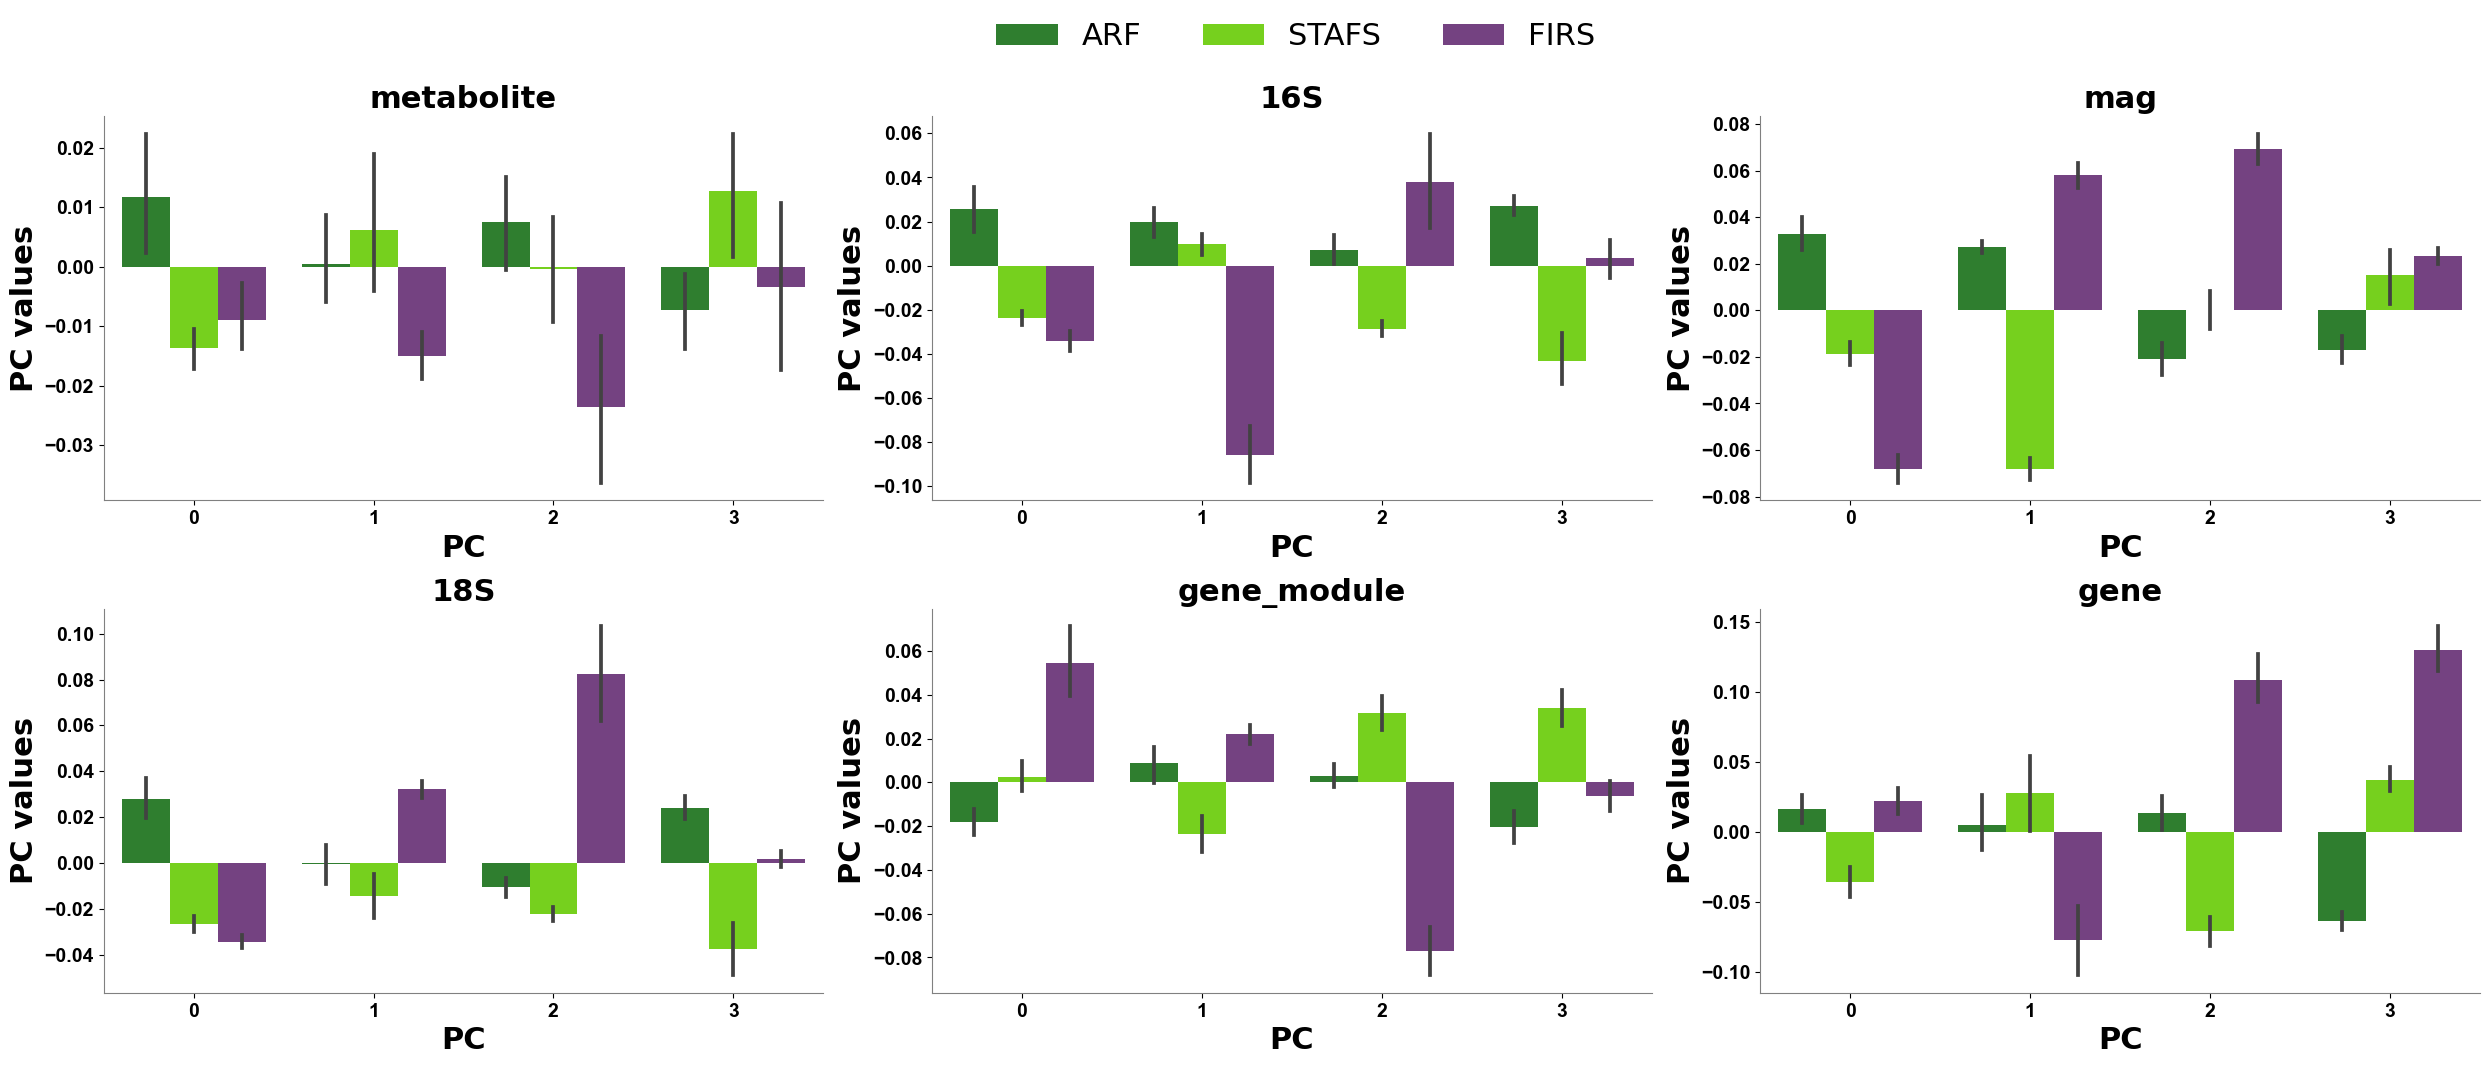

In [19]:
palette=["#228b22","#76ee00","#7a378b"]
fig, axn = plt.subplots(2, 3, figsize=(25, 10))
axn = axn.flatten()

for ax, (tblid, (ord_, dist_, _)) in zip(axn, rpca_independent.items()):
    
    ord_plt = ord_.samples
    ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                         for c in ord_plt.columns}, axis=0).reset_index()
    sns.barplot(x='level_0', y='PC', hue='facility', hue_order = ['ARF', 'STAFS', 'FIRS'], data=ord_plt, ax=ax, palette=palette)
    
    ax.set_xlabel('PC',
                  color='black',
                  weight='bold',
                  fontsize=22)
    ax.set_ylabel('PC values',
                  color='black',
                  weight='bold',
                  fontsize=22)

    ax.set_title(tblid,
                  color='black',
                  weight='bold',
                  fontsize=22)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')

    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(14)
    ax.legend_.remove()
    
plt.tight_layout()

legend = ax.legend(loc=2, 
           bbox_to_anchor=(-1.1, 2.6),
           prop={'size':22},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=3, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    

plt.show()

In [38]:
#feature trajectories informed by ordination results
omic_pc = {'metabolite': 'PC1', '16S': 'PC2', 'mag': 'PC3',
            '18S': 'PC2', 'gene_module': 'PC2', 'gene': 'PC2',
            'metabolomics': 'PC1'}

#omic_to_pc = {'metabolite': 'PC1', 'mag': 'PC3',
#              '18S': 'PC2', 'gene_module': 'PC2', 'gene':'PC2'}

# make each log-ratio based on axis
quantile_use = 0.1

def rpca_feat_trajectory(tables, rpca_results,
                         metadata, pc_dict):

    features_used_all = {}
    lr_cols = []
    metadata_logratios = metadata.copy()

    for modality, (ord_, _, _) in rpca_results.items():
        if modality == "16S":
            continue
        elif modality == "gene":
            continue

        print(modality)
        ids_to_keep = metadata_logratios.index
        table_ = tables[modality].filter(ids_to_keep, axis='sample')
        table_ = tables[modality].to_dataframe()
        pc_ = pc_dict[modality]
        feats_ = ord_.features[[pc_]].sort_values(ascending=False, by=pc_)

        for i_ in range(1, 1500):
            num = feats_.iloc[:i_, :].index
            den = feats_.iloc[-i_:, :].index
            features_used_all[modality] = [num[:19], den[:19]]
            lr_ = np.log(table_.loc[num, :].sum(0)) - np.log(table_.loc[den, :].sum(0))
            
            if (sum(np.isfinite(lr_)) / table_.shape[1]) >= 0.99:
                break
        
        print(i_)
        print(sum(np.isfinite(lr_)) / table_.shape[1])
        lr_ = lr_.sparse.to_dense()
        lr_[~np.isfinite(lr_)] = np.nan
        metadata_logratios[modality + '_logratio'] = lr_
        lr_cols.append(modality + '_logratio')

    return metadata_logratios, features_used_all

In [23]:
#rpca_independent['metabolite'] #(ord_, dist_, reconstruction_error)
#rpca_independent, metadata, tables

metab_ids = pd.read_excel('../network/metabolite_formulas.xlsx', index_col=0)
metab_ids.index = ['metab_' + str(x) for x in metab_ids.index]
metab_ids_class = metab_ids.dropna(subset=['most specific class'])

bt_tmp, df_tmp = tables['metabolite'], tables['metabolite'].to_dataframe()
ord_tmp = rpca_independent['metabolite'][0].features
keep_metab = set(metab_ids_class.index) & set(bt_tmp.ids('observation'))
bt_tmp = bt_tmp.filter(keep_metab, axis='observation')
df_tmp = df_tmp.loc[list(keep_metab), :]
ord_tmp = ord_tmp.loc[list(keep_metab), :]

#update
tables['metabolite'] = bt_tmp
rpca_independent['metabolite'][0].features = ord_tmp

In [49]:
#update col names in ordination results
for ax, (tblid, (ord_, _, _)) in zip(axn, rpca_independent.items()):
    print(tblid)
    #prepare dataframe
    ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                               2:'PC3', 3:'PC4'})
    ord_features = ord_.features.rename(columns={0:'PC1', 1:'PC2', 
                                                 2:'PC3', 3:'PC4'})
    rpca_independent[tblid][0].samples = ord_samples
    rpca_independent[tblid][0].features = ord_features

metabolite
16S
mag
18S
gene_module
gene


In [52]:
rpca_independent_sub = rpca_independent.copy()
del rpca_independent_sub['metabolomics']

rpca_independent_sub.keys()

dict_keys(['metabolite', '16S', 'mag', '18S', 'gene_module', 'gene'])

In [53]:
metadata_logratios, features_used = rpca_feat_trajectory(tables, rpca_independent_sub, 
                                                         metadata, omic_pc)

metabolite
24
0.9919786096256684
mag
12
0.9919786096256684
18S
1499
0.9117647058823529
gene_module
5
0.9973262032085561


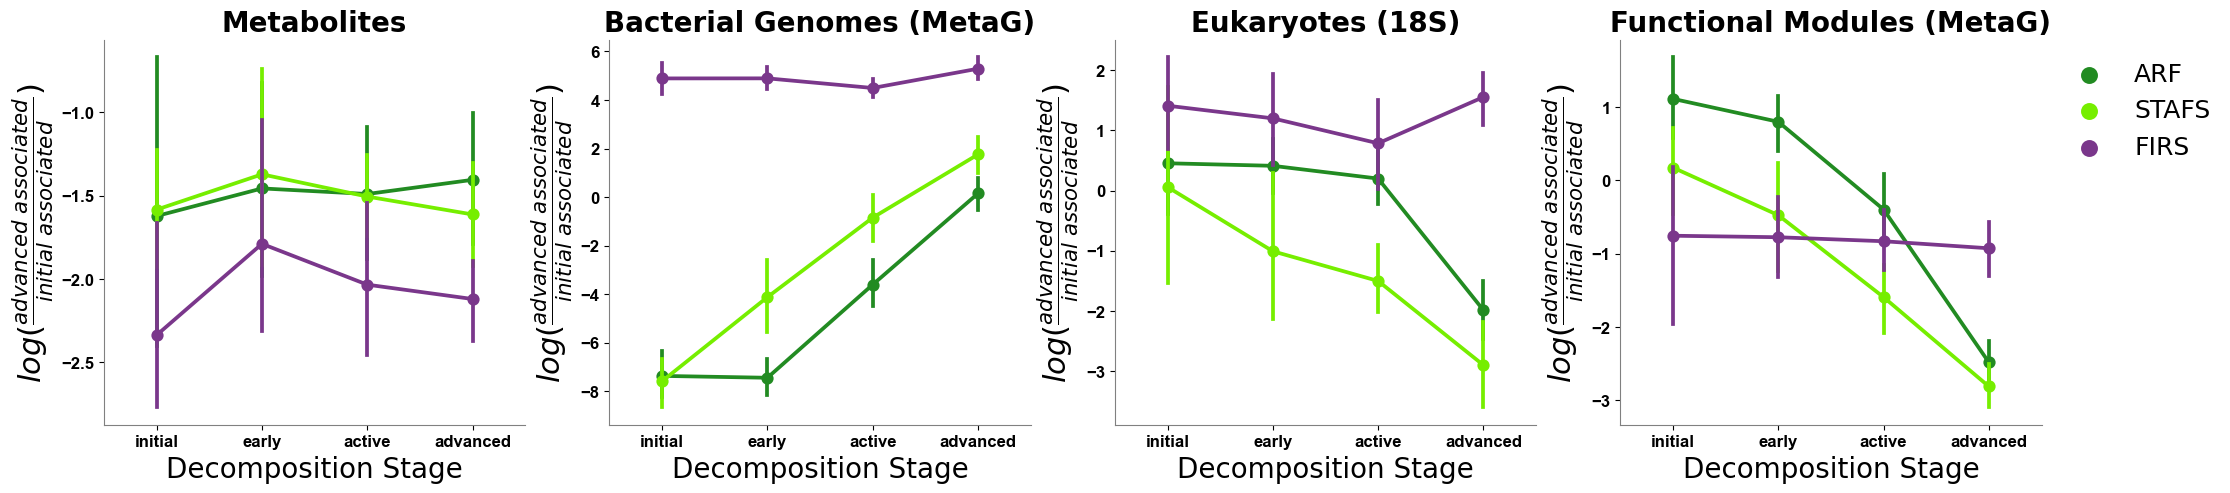

In [54]:
fig, axn = plt.subplots(1, 4, figsize=(5*5, 5))

titles_ =  {'mag_logratio':'Bacterial Genomes (MetaG)',
            '18S_logratio':'Eukaryotes (18S)',
            'gene_module_logratio':'Functional Modules (MetaG)',
            'metabolite_logratio':'Metabolites'}

lr_cols = ['metabolite_logratio', 'mag_logratio', 
           '18S_logratio', 'gene_module_logratio']

palette=["#228b22","#76ee00","#7a378b"]

for ax, lr_ in zip(axn, lr_cols):

    #metadata_logratios[lr_] = -1*metadata_logratios[lr_]
    sns.pointplot(x='add_0c_group', y=lr_, hue='facility', 
                  hue_order = ['ARF', 'STAFS', 'FIRS'], palette=palette,
                  order = ['initial', 'early', 'active', 'advanced'],
                  data=metadata_logratios, ax=ax)
    ax.set_xlabel('Decomposition Stage', color='black', fontsize=20)
    ax.set_ylabel('$log(\\frac{advanced\,\,associated}{initial\,\,associated})$',
                  color='black', weight='bold', fontsize=22)
    ax.set_title(titles_[lr_], color='black', weight='bold', fontsize=20)

    # fix backround
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
    for tick in ax.get_yticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(12)
    for tick in ax.get_xticklabels():
        tick.set_fontproperties('arial')
        tick.set_weight('bold')
        tick.set_color("black")
        tick.set_fontsize(12)
    ax.legend_.remove()

legend = ax.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size':18}, title="",
                   fancybox=True, framealpha=.0, ncol=1, markerscale=1.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
# plt.savefig('../results/figures/rpca-log-ratios.png',
#             dpi=600, 
#             bbox_inches='tight',
#             edgecolor='none')
plt.show()

# joint-rpca

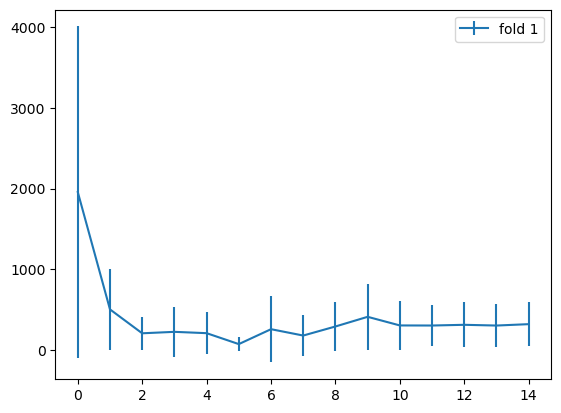

In [ ]:
# # ONLY RUN ON FIRST ITERATION
# cv_all_joint = {}
# fold = 0
# ord_jnt, dist_jnt, cv_jnt = joint_rpca([v for k, v in tables.items()
#                                         if k in ['mag', '18S', 'gene_module', 'gene', 'metabolite']],
#                                         n_components=4,
#                                         max_iterations=15,
#                                         min_feature_count=10,
#                                         sample_metadata=metadata,
#                                         train_test_column='traintest_%i' % fold)
# cv_all_joint[0] = cv_jnt
# joint_rpca_results = {'joint': (ord_jnt, None, None)}

# # check CV error
# cv_all_joint_df = pd.concat(cv_all_joint).reset_index().rename({'level_0':'fold'}, axis=1)
# for f, df_ in cv_all_joint_df.groupby('fold'):
#     plt.errorbar(df_.iteration, df_['mean_CV'], yerr=df_['std_CV'], label='fold %i' % (f + 1))
# plt.legend()
# plt.show()

In [ ]:
#save results
#ord_jnt.write('../results/joint-rpca/joint_ord_3PCs.txt')
#dist_jnt.write('../results/joint-rpca/joint_dist_3PCs.txt')
#cv_jnt.to_csv('../results/joint-rpca/joint_cv_3PCs.csv')

In [8]:
# load results form prior run
joint_rpca_results = {'joint': (OrdinationResults.read('../results/joint-rpca/joint_ord_4PCs.txt'), None, None) }

### 2D and 3D Scatterplots

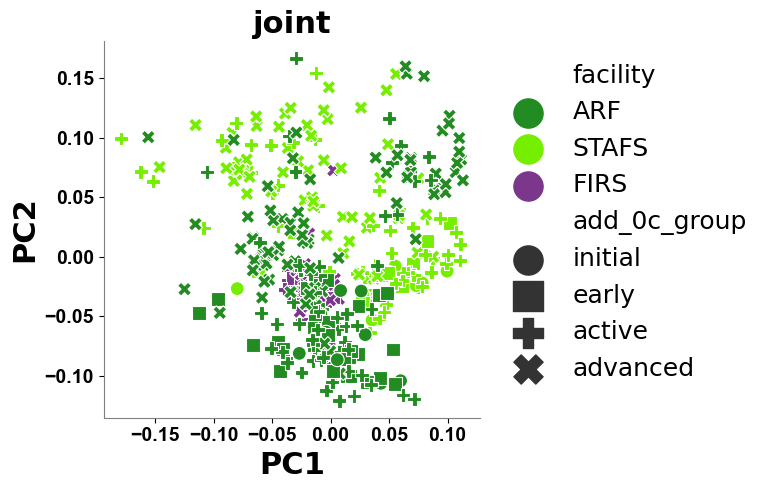

In [9]:
palette=["#228b22","#76ee00","#7a378b"]
markers = {"initial": "o", "early": "s", "active": "P", "advanced": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
                        palette=palette, markers=markers, style='add_0c_group',
                        style_order=['initial', 'early', 'active', 'advanced'], 
                        subplots=None, figsize=(5, 5))

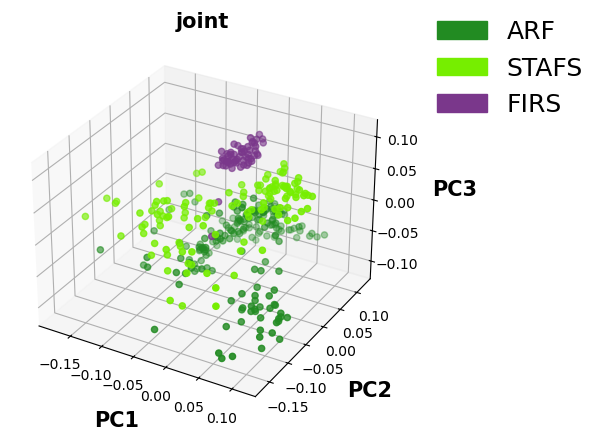

In [ ]:
ord_scatter_3D(joint_rpca_results, metadata, 
               hue="facility", hue_order=['ARF', 'STAFS', 'FIRS'], 
               pcs=["PC1","PC2","PC3"], palette=["#228b22","#76ee00","#7a378b"], 
               subplots=None, figsize=(5, 5))

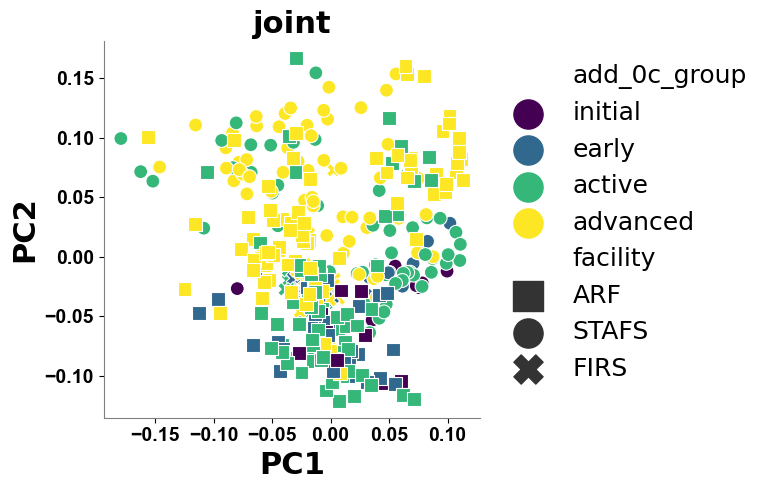

In [12]:
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]
markers = {"ARF": "s", "STAFS": "o", "FIRS": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
                        palette=palette, markers=markers, 
                        style='facility', style_order=['ARF', 'STAFS', 'FIRS'], 
                        subplots=None, figsize=(5, 5))

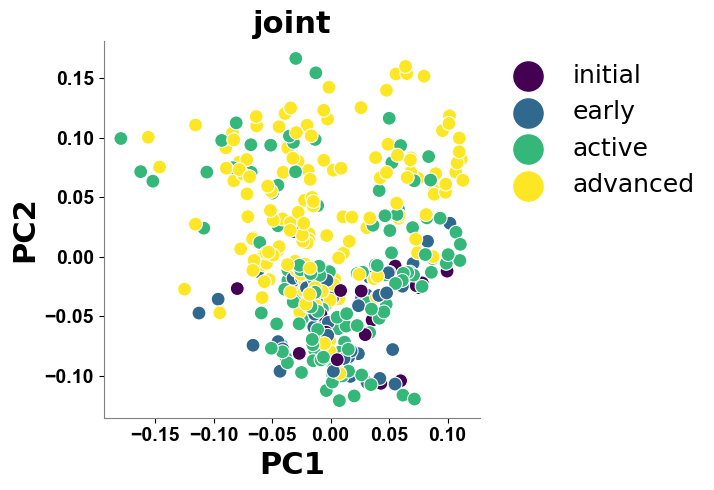

In [15]:
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]
markers = {"ARF": "s", "STAFS": "o", "FIRS": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
                        palette=palette, markers=None, style=None, style_order=None, 
                        subplots=None, figsize=(5, 5))

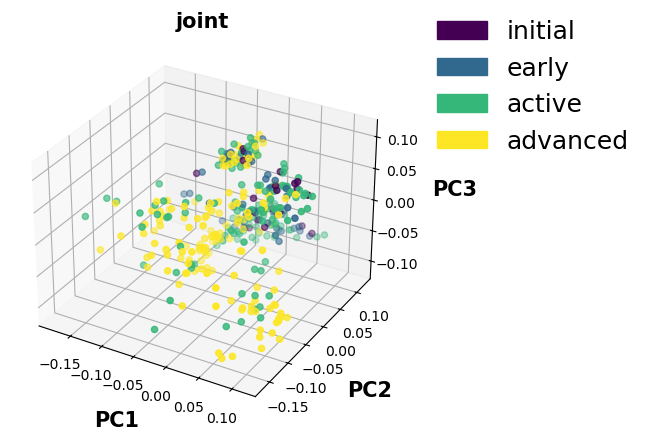

In [ ]:
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]

ord_scatter_3D(joint_rpca_results, metadata, 
               hue="add_0c_group", hue_order=['initial', 'early', 'active', 'advanced'], 
               pcs=["PC1","PC2","PC3"], palette=palette, 
               subplots=None, figsize=(5, 5))

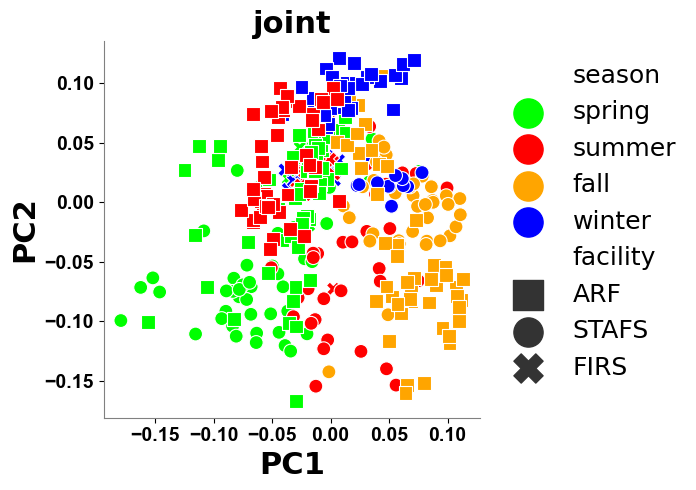

In [ ]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]
markers = {"ARF": "s", "STAFS": "o", "FIRS": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="season", hue_order=['spring', 'summer','fall','winter'], 
                        palette=palette, markers=markers, 
                        style='facility', style_order=['ARF', 'STAFS', 'FIRS'], 
                        subplots=None, figsize=(5, 5))

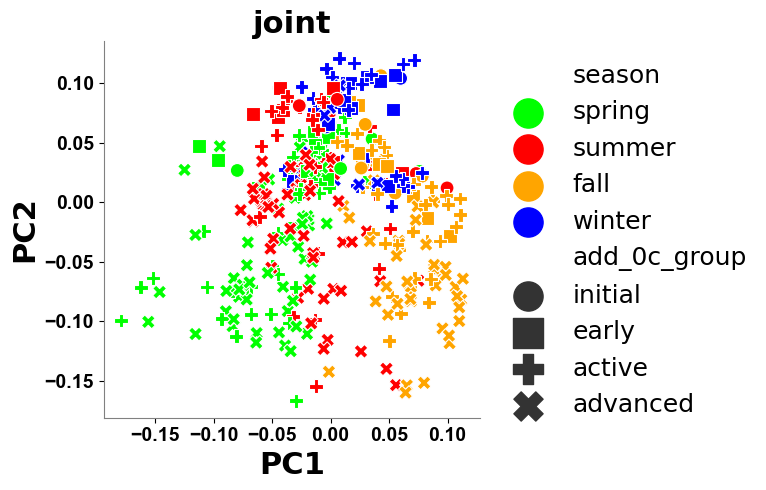

In [ ]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]
markers = {"initial": "o", "early": "s", "active": "P", "advanced": "X"}

ordination_scatterplots(joint_rpca_results, metadata, x="PC1", y="PC2", 
                        hue="season", hue_order=['spring', 'summer','fall','winter'], 
                        palette=palette, markers=markers, 
                        style='add_0c_group', style_order=['initial', 'early', 'active','advanced'], 
                        subplots=None, figsize=(5, 5))

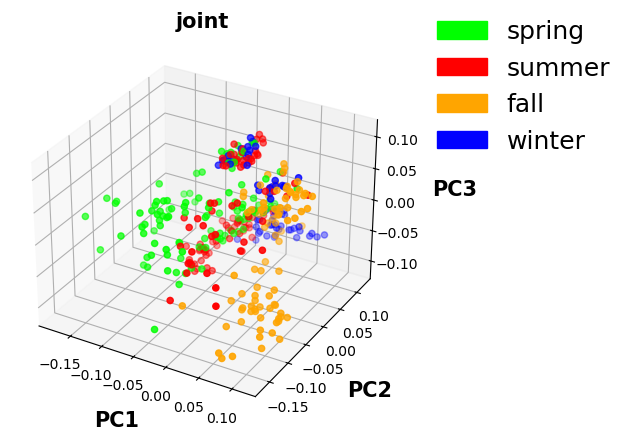

In [ ]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]

ord_scatter_3D(joint_rpca_results, metadata, 
               hue="season", hue_order=['spring', 'summer','fall','winter'],  
               pcs=["PC1","PC2","PC3"], palette=palette, 
               subplots=None, figsize=(5, 5))

### Strip plots

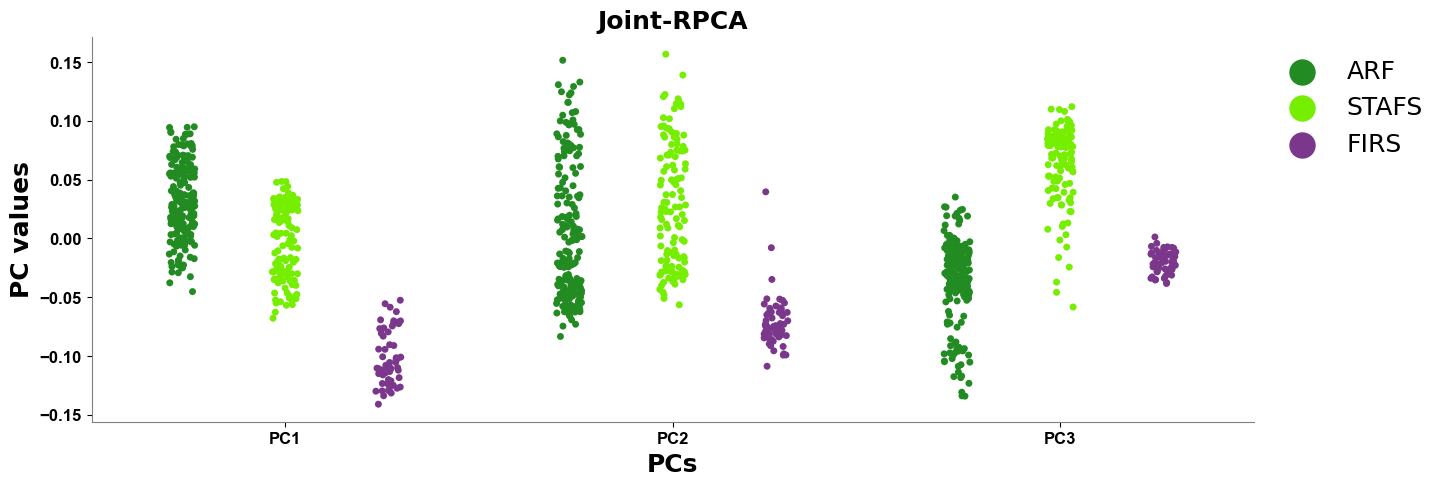

In [ ]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

ord_jnt = joint_rpca_results['joint'][0]
ord_plt = ord_jnt.samples.rename(columns={0:'PC1', 1:'PC2', 2:'PC3', 3:'PC4'})
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
sns.stripplot(x='level_0', y='PC', hue='facility', hue_order=['ARF', 'STAFS', 'FIRS'], 
              palette=palette, data=ord_plt, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-location.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

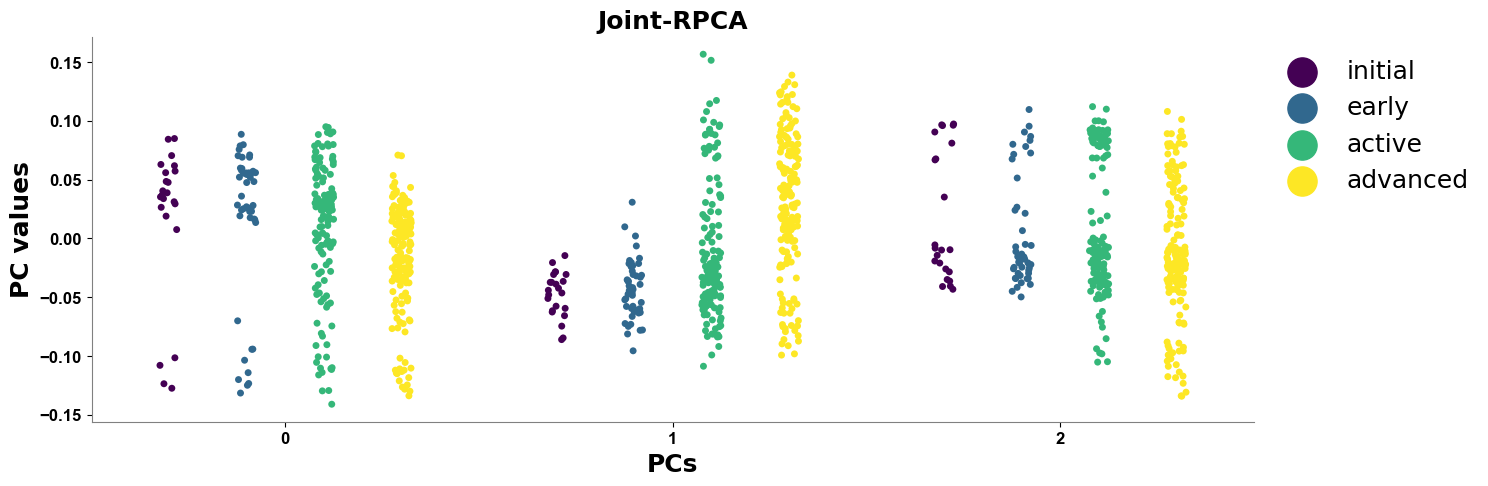

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15, 5))
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]


ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
sns.stripplot(x='level_0', y='PC', hue='add_0c_group', data=ord_plt, palette=palette,
              hue_order = ['initial', 'early', 'active', 'advanced'], ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

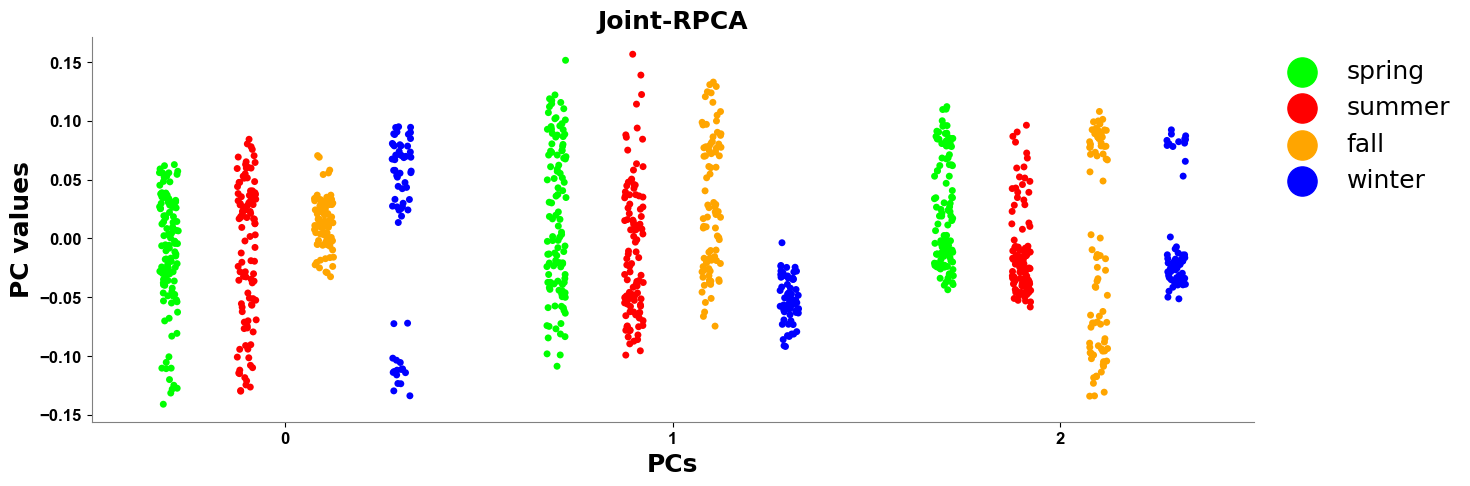

In [ ]:
palette=["#00FF00","#FF0000","#FFA500", "#0000FF"]

fig, ax = plt.subplots(1,1, figsize=(15, 5))

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
#ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='season', data=ord_plt,
              hue_order=['spring', 'summer','fall','winter'], 
              palette=palette, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-seasons.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

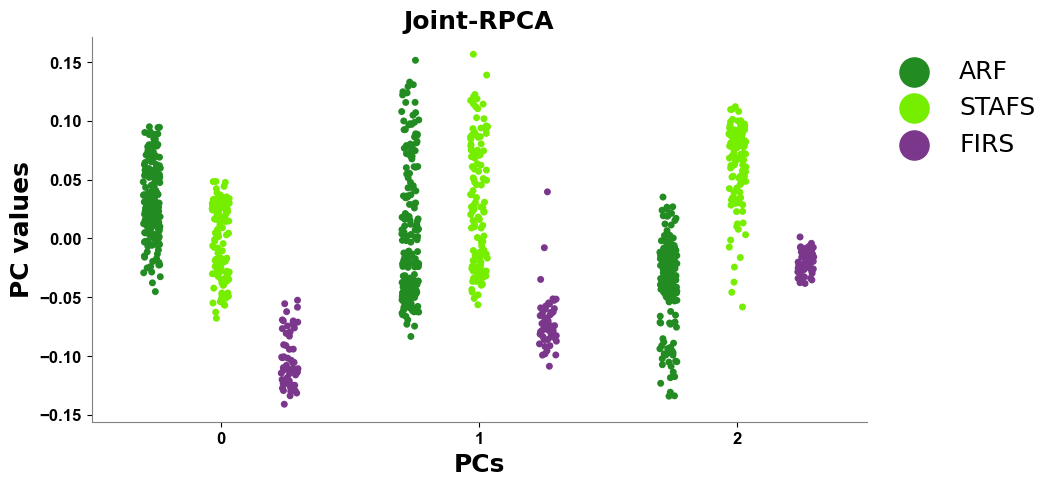

In [ ]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(10, 5))

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()

ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='facility', hue_order=['ARF', 'STAFS', 'FIRS'], 
              palette=palette, data=ord_plt, ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-location-PC3.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

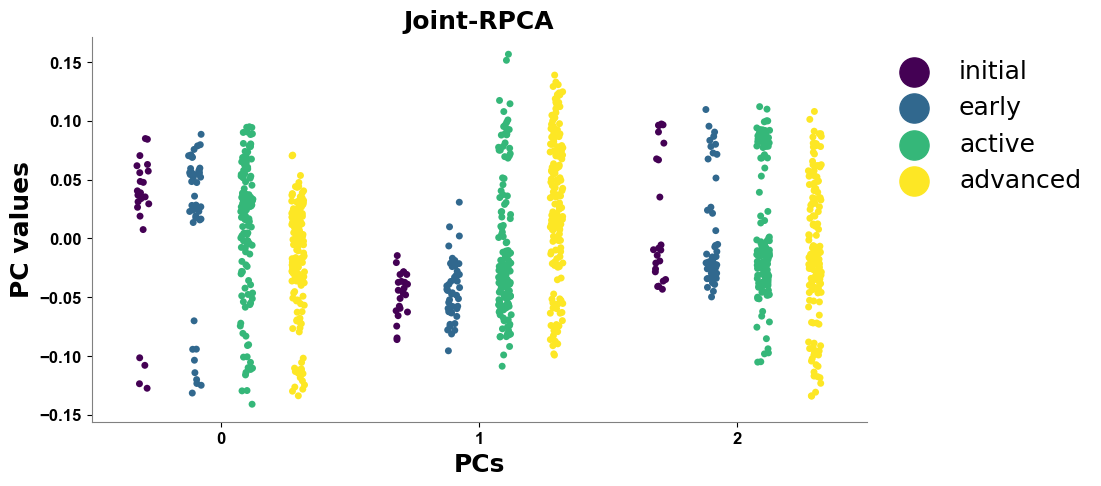

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))
palette=["#440154FF","#31688EFF","#35B779FF","#FDE725FF"]

ord_plt = ord_jnt.samples
ord_plt = pd.concat({c:pd.concat([ord_plt[[c]].rename({c:'PC'}, axis=1), metadata], axis=1, sort=True).reset_index()
                     for c in ord_plt.columns}, axis=0).reset_index()
ord_plt = ord_plt[ord_plt["level_0"] != "PC4"]

sns.stripplot(x='level_0', y='PC', hue='add_0c_group', data=ord_plt, palette=palette,
              hue_order=['initial', 'early', 'active', 'advanced'], ax=ax, dodge=True)

ax.set_xlabel('PCs',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC values',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
#plt.savefig('../results/figures/rpca-pc-loadings-time-PC3.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

### Point plots

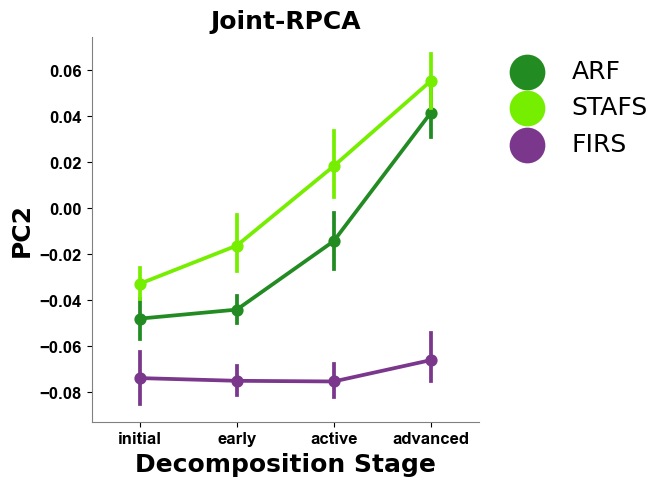

In [ ]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))
ord_plt = pd.concat([ord_jnt.samples, metadata], axis=1, sort=True)
ord_plt.rename(columns={0:'PC1', 1:'PC2', 2:'PC3'}, inplace=True)
sns.pointplot(x='add_0c_group', y='PC2', hue='facility', hue_order=['ARF', 'STAFS', 'FIRS'], 
              order=['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC2',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc2-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

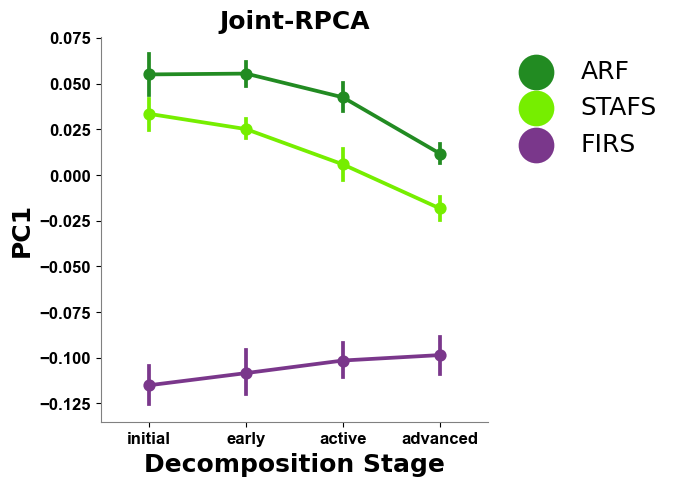

In [ ]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))
sns.pointplot(x='add_0c_group', y='PC1', hue='facility', hue_order=['ARF', 'STAFS', 'FIRS'], 
              order=['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC1',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc1-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

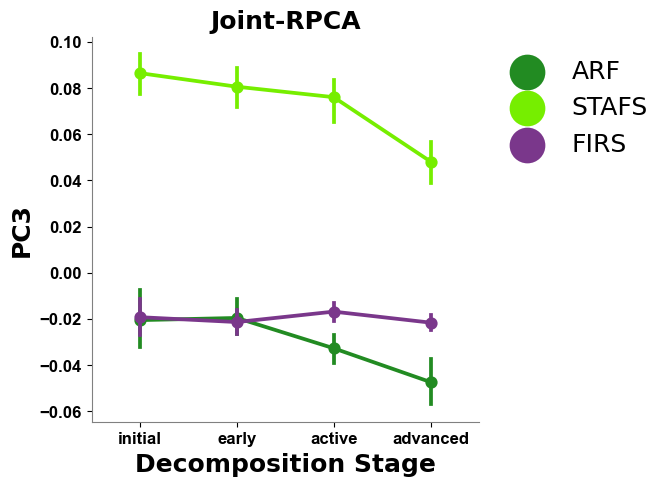

In [ ]:
palette=["#228b22","#76ee00","#7a378b"]

fig, ax = plt.subplots(1,1, figsize=(5, 5))
sns.pointplot(x='add_0c_group', y='PC3', hue='facility', 
              hue_order=['ARF', 'STAFS', 'FIRS'], 
              order=['initial', 'early', 'active', 'advanced'],
              data=ord_plt, ax=ax, palette=palette,)

ax.set_xlabel('Decomposition Stage',
              color='black',
              weight='bold',
              fontsize=18)
ax.set_ylabel('PC3',
              color='black',
              weight='bold',
              fontsize=18)

ax.set_title('Joint-RPCA',
              color='black',
              weight='bold',
              fontsize=18)

# fix backround
ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')

for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_weight('bold')
    tick.set_color("black")
    tick.set_fontsize(12)

legend = ax.legend(loc=2, 
           bbox_to_anchor=(1, 1),
           prop={'size':18},
           title="",
           fancybox=True,
                    framealpha=.0,
           ncol=1, markerscale=3.5)
legend.get_title().set_fontsize('16')
# increase the line width in the legend 
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
for line in legend.get_lines()[:]:
    line.set_linewidth(2.0)
    
#plt.savefig('../results/figures/rpca-pc3-loadings-location-time.png',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()

### Kruskal Wallis

In [ ]:
metadata_subset = pd.read_csv('../network/split-matched-data/metadata.tsv', sep='\t', index_col=0)
ord_joint = ord_jnt
#ord_joint = OrdinationResults.read('../results/joint-rpca/joint_ord_3PCs.txt')
ord_joint_samps = ord_joint.samples.copy()
ord_joint_samps.index.name = 'sample_name'
ord_joint_samps.reset_index(inplace=True)
merged_table = pd.merge(ord_joint_samps, metadata_subset, on='sample_name')
merged_table.head()

sample_name       PC1       PC2       PC3  \
0  soil.hip.SHSU.2016.007.2016.05.01.day17 -0.071575 -0.052915  0.025669   
1   soil.hip.SHSU.2016.067.2016.09.22.day7  0.050705 -0.022153  0.025820   
2    soil.hip.UTK.K016.02.2016.04.23.day11 -0.032014  0.037822 -0.044184   
3    soil.hip.UTK.K016.12.2017.06.09.day16 -0.056717  0.020795 -0.080051   
4    soil.hip.UTK.K016.03.2016.05.25.day20 -0.053779 -0.059432 -0.044503   

        PC4  season       subjects      add_0c add_0c_group facility  ...  \
0  0.037550  spring  shsu.2016.007  373.611111     advanced    STAFS  ...   
1  0.042789  summer       2016.067  173.400000       active    STAFS  ...   
2  0.007564  spring    UTK.K016.02  185.833333       active      ARF  ...   
3  0.007495  summer    UTK.K016.12  319.600000     advanced      ARF  ...   
4 -0.020803  spring    UTK.K016.03  366.944444     advanced      ARF  ...   

   traintest_0 traintest_1 traintest_2 traintest_3 traintest_4 traintest_5  \
0        train       train       train       train       train       train   
1        train       train       train       train       train       train   
2        train       train       train       train       train       train   
3        train       train       train       train       train       train   
4        train       train       train       train       train       train   

  traintest_6 traintest_7 traintest_8 traintest_9  
0       train       train       train       train  
1       train       train       train       train  
2       train       train       train       train  
3       train       train       train       train  
4       train       train       train       train  

[5 rows x 21 columns]

In [ ]:
# Group the numerical data based on the categorical data
cats_of_interest = ['facility', 'season', 'add_0c_group']
n_PCS = 4
kw_df_joint = []

for cat_of_interest in cats_of_interest:
    kw_joint_cat = pd.DataFrame()
    kw_h = []
    kw_p = []

    for i in range(n_PCS):
        PC = f'PC{i+1}'
        grouped = merged_table.groupby(cat_of_interest)[PC]
        groups = [group for _, group in grouped]

        # Perform the Kruskal-Wallis test
        h, p = kruskal(*groups)
        # print("Facility Kruskal Wallis Tests by Axis")
        # print("Axis ",i+1)
        # print("H-statistic:", h)
        # print("p-value:", p)
        kw_h.append(h)
        kw_p.append(p)

    kw_joint_cat_df = pd.DataFrame(list(zip(kw_h, kw_p)), 
                                   columns = ['H-statistic', 'p-value'],
                                   index=[f'PC{i+1}' for i in range(n_PCS)])
    kw_df_joint.append(kw_joint_cat_df)

kw_df_joint = pd.concat(kw_df_joint, axis=1, keys=cats_of_interest)

In [ ]:
kw_df_joint

facility                    season               add_0c_group  \
    H-statistic       p-value H-statistic       p-value  H-statistic   
PC1    8.297189  1.578659e-02  214.832163  2.628971e-46    10.533133   
PC2   72.679347  1.651507e-16   86.143455  1.474668e-18    95.311419   
PC3  289.100862  1.669342e-63   10.976511  1.185357e-02     9.904243   
PC4  260.927105  2.189773e-57   15.475195  1.452465e-03    18.782294   

                   
          p-value  
PC1  1.453782e-02  
PC2  1.582661e-20  
PC3  1.939789e-02  
PC4  3.032486e-04

In [ ]:
# # Group the numerical data based on the categorical data
# for i in range (4):
#     grouped = merged_table.groupby('climate')[i]
#     groups = [group for _, group in grouped]

#     # Perform the Wilcox test
#     u, p = mannwhitneyu(*groups)
#     print("Climate Wilcox Tests by Axis")
#     print("Axis ",i+1)
#     print("U-statistic:", u)
#     print("p-value:", p)